### Imports

In [1]:
# 1. Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

### Display Setup

In [2]:
# Magic command to display plots directly in the notebook
%matplotlib inline

# Increase default plot size for better visibility
plt.rcParams['figure.figsize'] = [12, 8]

def show_images(images, titles):
    """
    Helper function to display multiple images side-by-side.
    Arguments:
        images: List of images (numpy arrays).
        titles: List of titles for each image.
    """
    n = len(images)
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(1, n, i+1)
        
        # Check if image is grayscale or color
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            # Convert BGR (OpenCV) to RGB (Matplotlib)
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

### Data Loading

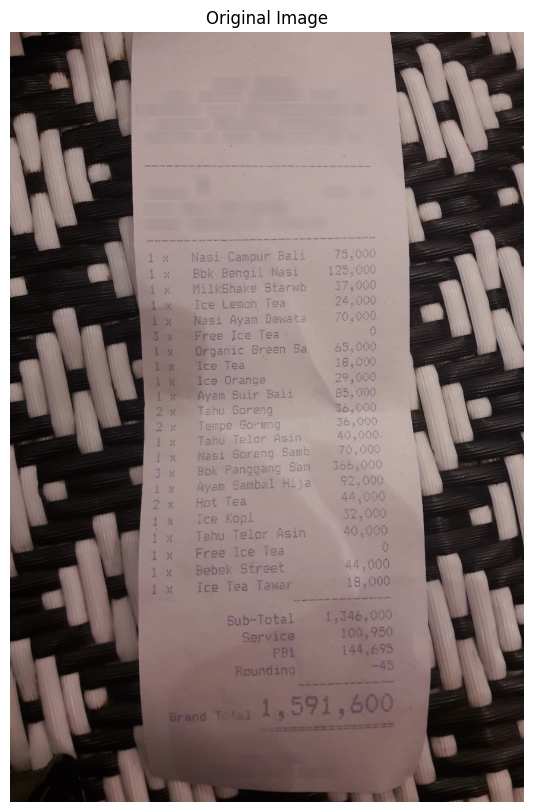

In [3]:
# Load an example image
image_path = '../data/cord/raw/train/image_0.png'

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at path: {image_path}")
else: 
    original_image = cv2.imread(image_path)

# Display the original image
show_images([original_image], ['Original Image'])


### Convert to GreyScale and Denoising

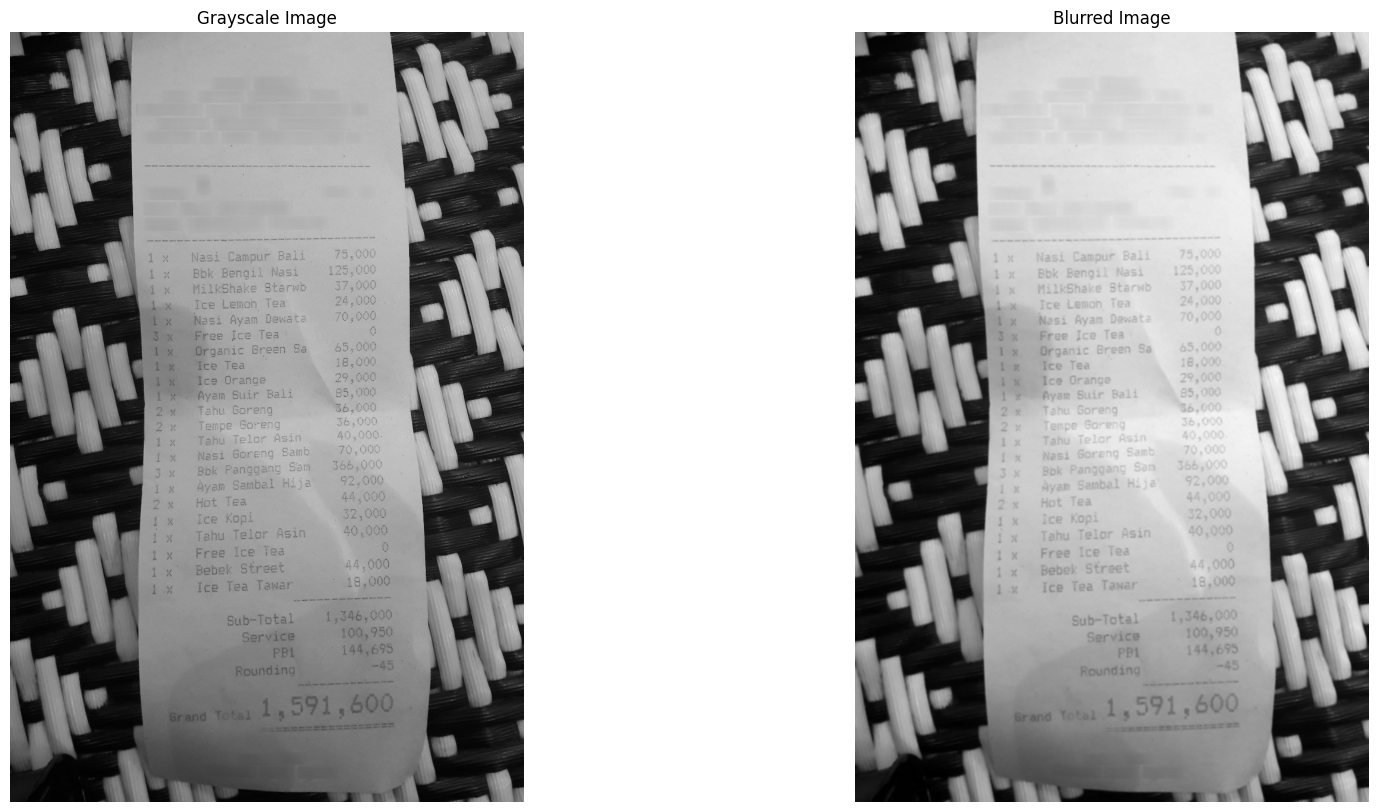

In [4]:
# Convert to Grayscale
grey_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Denoise the image using Gaussian Blur
blurred_image = cv2.GaussianBlur(grey_image, (5, 5), 0)

# Show the images
show_images([grey_image, blurred_image], ['Grayscale Image', 'Blurred Image'])

### Binarization-test

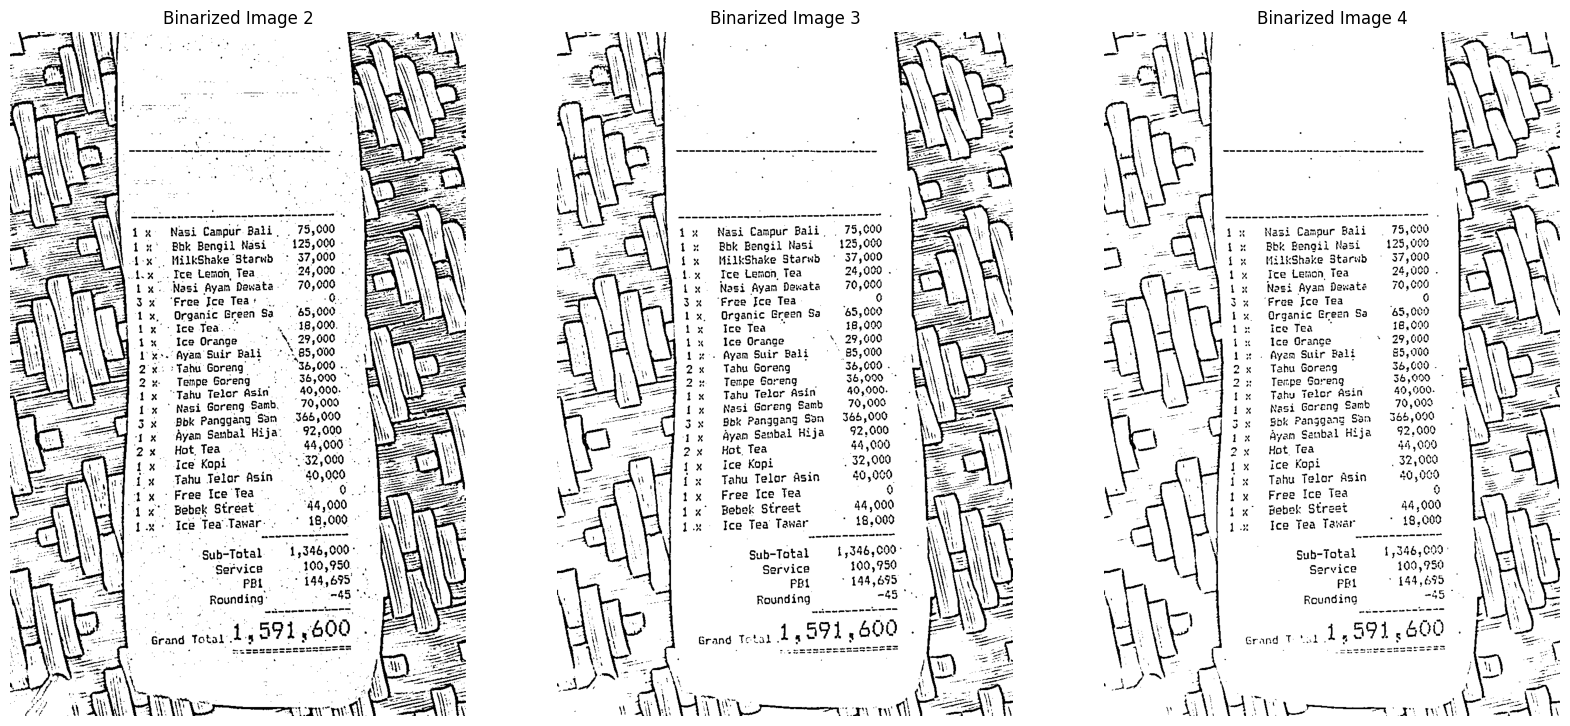

In [5]:
# Binarization using Adaptive Thresholding
# With comparing different C values to see the effect
# C values: 2, 3, 4 -> The C value is a constant subtracted from the mean
# Higher C value cleans more background noise but risks breaking thin text
# Lower C keeps text thick but adds noise.
# C = 3 seems to give the best results visually, but we will use Opening Morophological to more clean up the noise.
test_image_2 = cv2.adaptiveThreshold(blurred_image, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 11, 2) 
test_image_3 = cv2.adaptiveThreshold(blurred_image, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 11, 3) 
test_image_4 = cv2.adaptiveThreshold(blurred_image, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 11, 4) 

show_images([test_image_2, test_image_3, test_image_4], ['Binarized Image 2', 'Binarized Image 3', 'Binarized Image 4'])

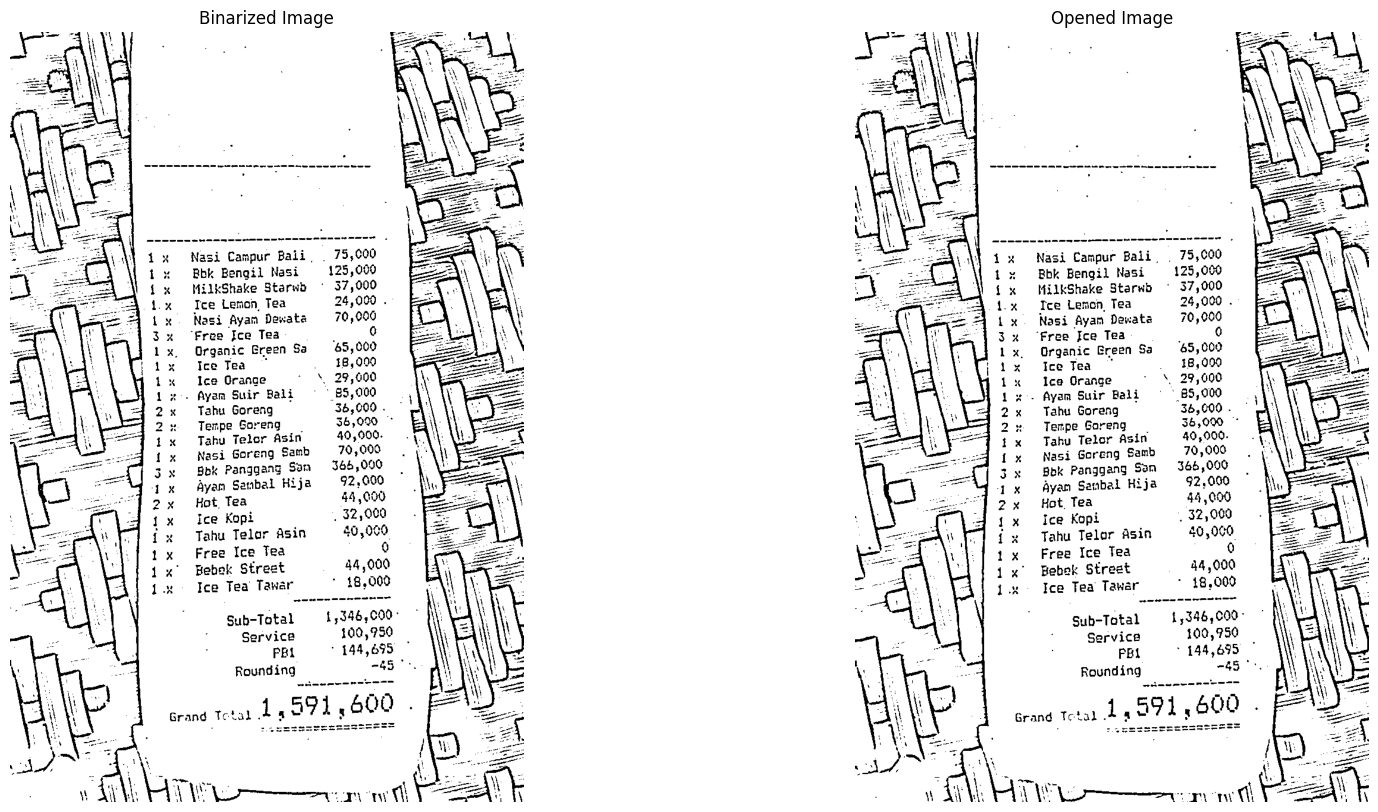

In [6]:
# True Binarization with C=3 and using Morphological Opening to clean up noise
binary_image = cv2.adaptiveThreshold(blurred_image, 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 3)

# Morphological Opening to remove small noise
kernel = np.ones((2,2), np.uint8)
opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Show the binary and opened images
show_images([binary_image, opened_image], ['Binarized Image', 'Opened Image'])

### Deskewing

📐 Detected Skew Angle: -1.5 degrees


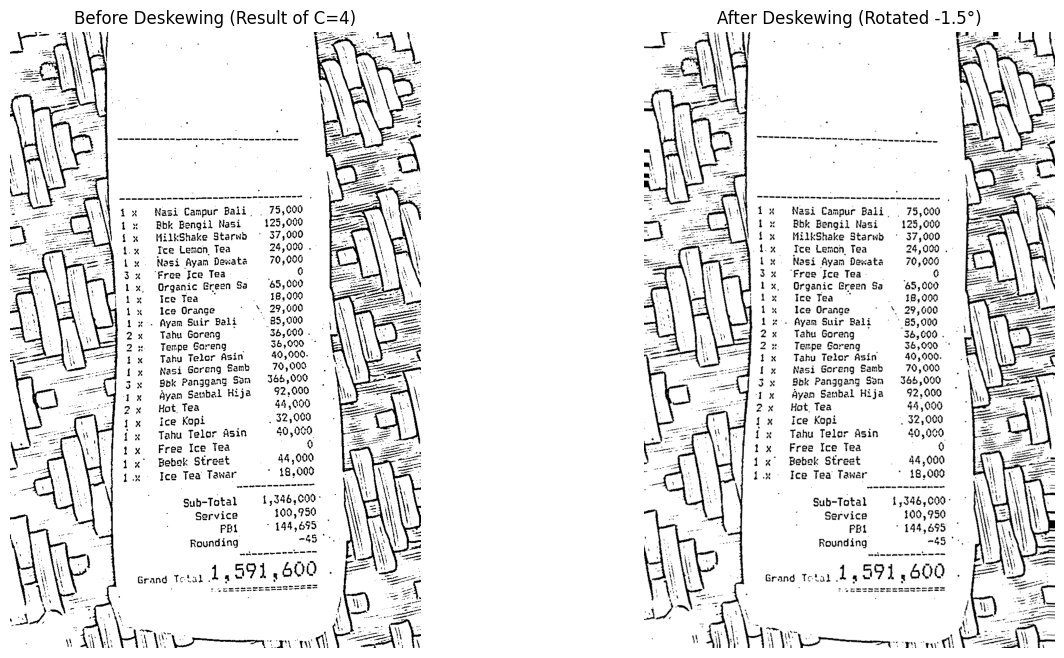

In [7]:
def compute_skew_angle(binary_image):
    """
    Calculates the skew angle of a binary image using the Projection Profile method.
    The logic tries different angles and checks which one maximizes the variance 
    of the horizontal projection (sharpest distinction between text lines and gaps).
    
    Args:
        binary_image: Input image (must be binary: black/white).
        
    Returns:
        float: The best angle found (in degrees).
    """
    # We need to invert the image for calculation (Text=White, Background=Black)
    # This is because we count the "sum" of white pixels.
    # If the input is already white background (standard receipt), we invert it.
    # We use OTSU to ensure a clean binary inversion for calculation purposes.
    inverted = cv2.bitwise_not(binary_image)

    # Search range: -5 to +5 degrees with 0.5 degree step
    # Receipts are rarely skewed more than this.
    angles = np.arange(-5, 6, 0.5)
    scores = []

    for angle in angles:
        # Get rotation matrix
        (h, w) = inverted.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Rotate the inverted binary image
        rotated = cv2.warpAffine(inverted, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        
        # Calculate Horizontal Projection (Sum of white pixels in each row)
        # If the image is perfectly horizontal, we get peaks (text) and zeros (gaps).
        projection = np.sum(rotated, axis=1)
        
        # Calculate Variance (Score)
        # Higher variance = sharper peaks/valleys = better alignment.
        score = np.sum((projection[1:] - projection[:-1]) ** 2)
        scores.append(score)

    # Return the angle with the highest score
    best_angle = angles[scores.index(max(scores))]
    return best_angle

def rotate_image(image, angle):
    """
    Rotates an image by a specific angle.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Use BORDER_REPLICATE to fill the corners with the edge color (cleaner look)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# --- EXECUTION ON YOUR IMAGE ---

# 1. Calculate the angle using the clean binary image (from previous step C=4)
detected_angle = compute_skew_angle(binary_image)
print(f"📐 Detected Skew Angle: {detected_angle} degrees")

# 2. Apply rotation to the binary image
# Note: We rotate the 'binary_image' image because that is what OCR needs.
final_deskewed = rotate_image(binary_image, detected_angle)

# 3. Visualize Before vs After
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray')
plt.title("Before Deskewing (Result of C=4)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_deskewed, cmap='gray')
plt.title(f"After Deskewing (Rotated {detected_angle}°)")
plt.axis('off')

plt.show()

### Advanced Deskewing (Hough Transform)

📐 Detected Angle (Hough): -1.17 degrees


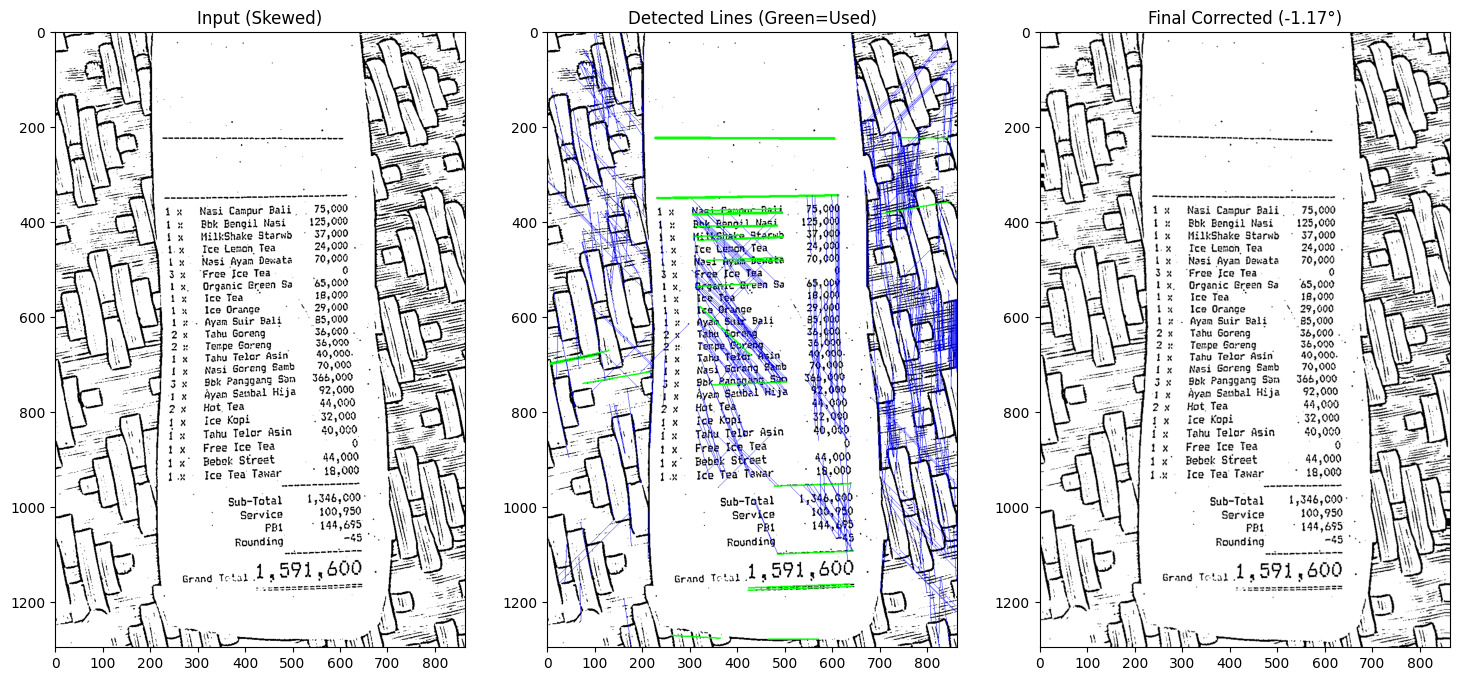

In [8]:
import math

def get_hough_skew_angle(image_binary):
    """
    Detects skew angle using Hough Transform (Line Detection).
    """
    # 1. Edge Detection (Canny)
    # Hough works on edges, not just binary blocks.
    edges = cv2.Canny(image_binary, 50, 150, apertureSize=3)

    # 2. Probabilistic Hough Line Transform
    # minLineLength=100: This is the KEY. It ignores short bamboo lines.
    # maxLineGap=20: Allows small gaps between letters in a line.
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=math.pi/180, 
        threshold=100, 
        minLineLength=100, 
        maxLineGap=20
    )

    if lines is None:
        print("⚠️ No lines detected!")
        return 0.0

    # 3. Calculate angle for every detected line
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate angle in degrees
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        
        # Filter: Ignore vertical lines (receipt edges) or extreme noise
        # We assume the skew is small (-45 to +45 degrees)
        if -45 < angle < 45:
            angles.append(angle)

    if not angles:
        print("⚠️ No horizontal lines found!")
        return 0.0

    # 4. Get the Median angle (Robust to outliers)
    median_angle = np.median(angles)
    return median_angle

def visualize_lines(image, angle):
    """Helper to draw detected lines for debugging"""
    debug_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Re-run detection just for visualization
    edges = cv2.Canny(image, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 100, minLineLength=100, maxLineGap=20)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            curr_angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            if -45 < curr_angle < 45:
                # Draw valid lines in GREEN
                cv2.line(debug_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            else:
                # Draw ignored lines in RED
                cv2.line(debug_img, (x1, y1), (x2, y2), (0, 0, 255), 1)
                
    return debug_img

# --- EXECUTION ---

# 1. Calculate Angle
# Use the 'binary_image' from previous step (C=3 + Morph)
hough_angle = get_hough_skew_angle(binary_image)
print(f"📐 Detected Angle (Hough): {hough_angle:.2f} degrees")

# 2. Rotate Image
# Note: warpAffine rotates Counter-Clockwise for positive angles.
# If the text is tilted down (positive slope), we usually need to rotate UP.
# Sometimes we need just 'hough_angle', sometimes '-hough_angle'.
# Let's try passing the angle directly first.
final_deskewed = rotate_image(binary_image, hough_angle)

# 3. Show Result with Debug Lines
debug_view = visualize_lines(binary_image, hough_angle)

plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.title("Input (Skewed)")

plt.subplot(1, 3, 2)
plt.imshow(debug_view)
plt.title(f"Detected Lines (Green=Used)")

plt.subplot(1, 3, 3)
plt.imshow(final_deskewed, cmap='gray')
plt.title(f"Final Corrected ({hough_angle:.2f}°)")

plt.show()

### Compar between Normal Deskewing, and the Advanced Deskewing

C:\Users\HD\AppData\Local\Temp\ipykernel_13960\2415224606.py:76: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HD\AppData\Local\Temp\ipykernel_13960\2415224606.py:76: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
g:\The Last Year\Computer Vision\Projects\receipt_ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
g:\The Last Year\Computer Vision\Projects\receipt_ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


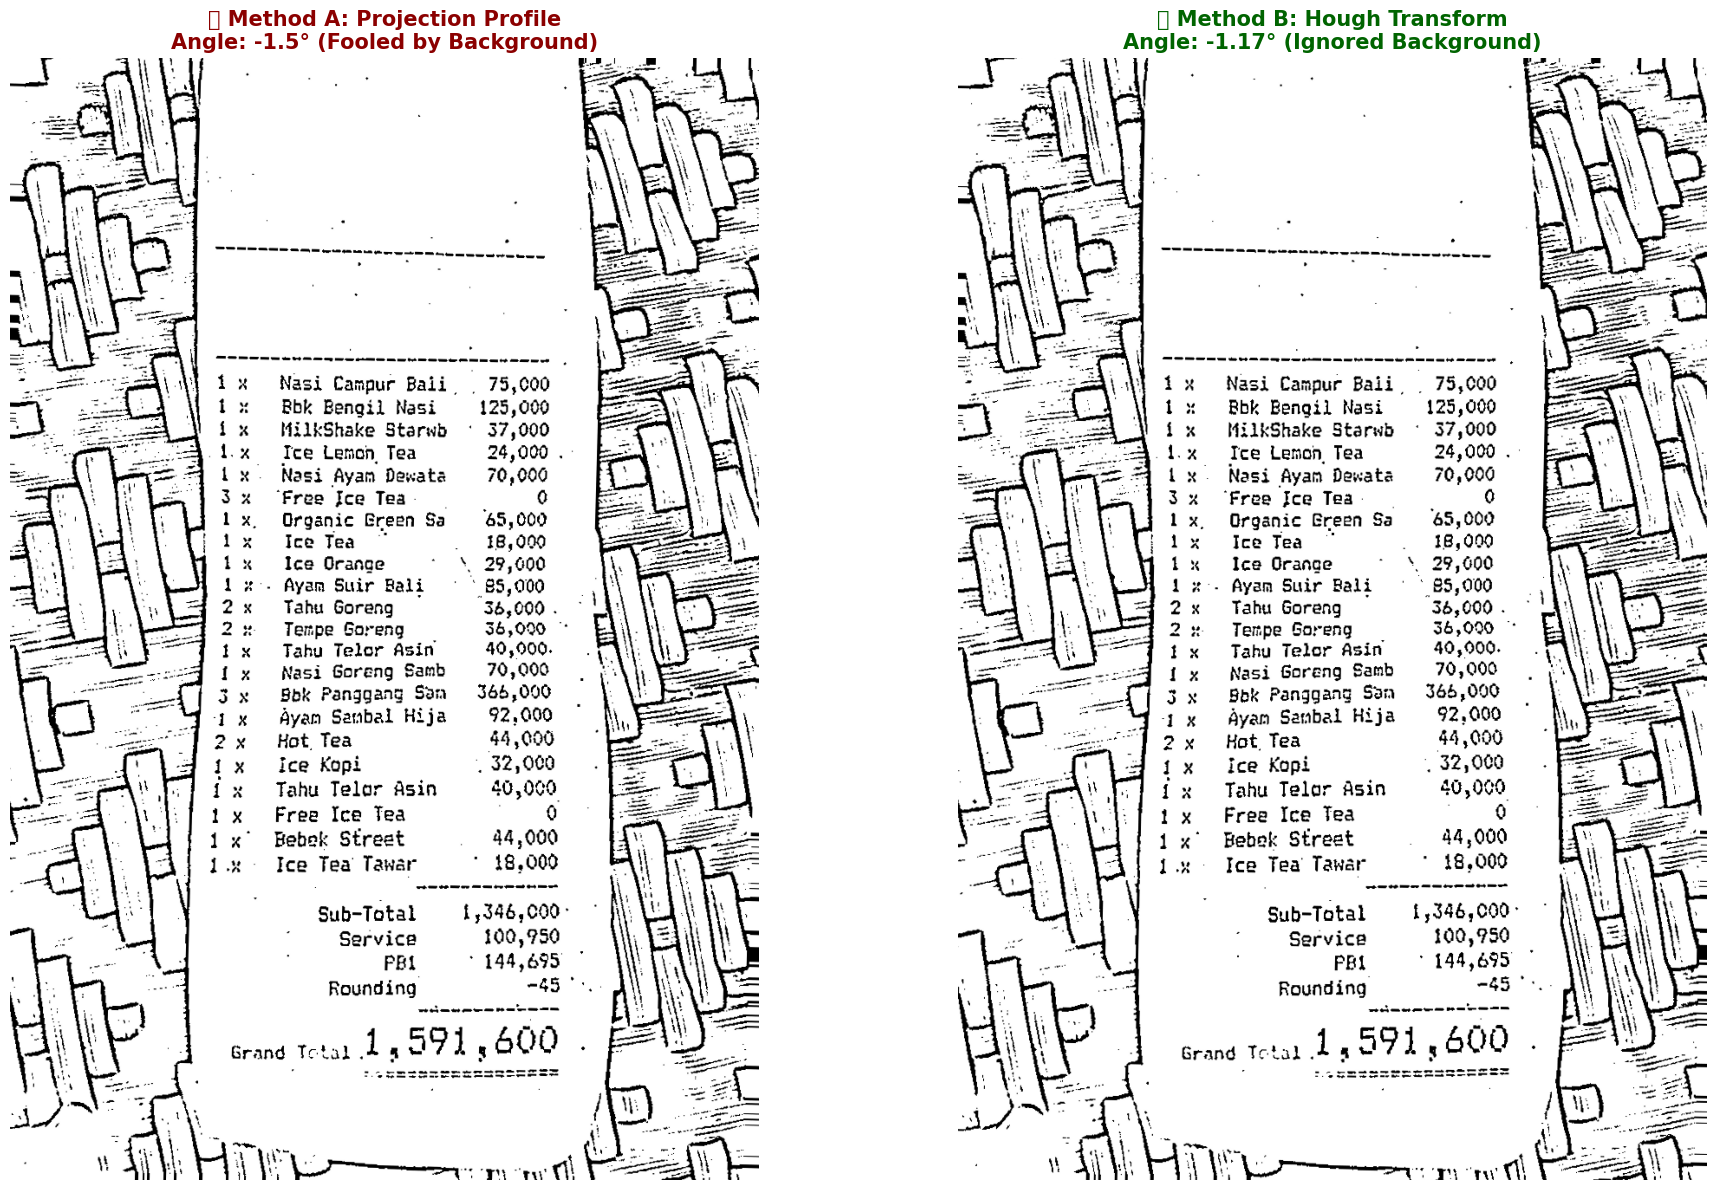

--------------------------------------------------
📊 FINAL STATS:
   • Projection Angle: -1.5° (Influenced by bamboo lines)
   • Hough Angle:      -1.17° (Focused on text lines)
   • Difference:       0.33°
--------------------------------------------------


In [9]:
# --- COMPARISON CELL: Projection Profile vs. Hough Transform ---

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

# 1. Define Helper Function for Rotation
def rotate_image_for_display(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Use REPLICATE to make edges look cleaner
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# 2. Method A: Projection Profile (The "Old" Way)
def method_projection_profile(binary_img):
    # Invert (Text=White)
    inverted = cv2.bitwise_not(binary_img)
    angles = np.arange(-5, 6, 0.5)
    scores = []
    
    for angle in angles:
        M = cv2.getRotationMatrix2D((binary_img.shape[1]//2, binary_img.shape[0]//2), angle, 1.0)
        rotated = cv2.warpAffine(inverted, M, (binary_img.shape[1], binary_img.shape[0]), flags=cv2.INTER_LINEAR)
        hist = np.sum(rotated, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        scores.append(score)
    
    return angles[scores.index(max(scores))]

# 3. Method B: Hough Transform (The "New" Way)
def method_hough_transform(binary_img):
    edges = cv2.Canny(binary_img, 50, 150, apertureSize=3)
    # minLineLength=100 filters out the bamboo noise
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 100, minLineLength=100, maxLineGap=20)
    
    if lines is None: return 0.0
    
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        if -45 < angle < 45:
            angles.append(angle)
            
    return np.median(angles) if angles else 0.0

# --- EXECUTION ---

# Calculate Angles
angle_proj = method_projection_profile(binary_image)
angle_hough = method_hough_transform(binary_image)

# Generate Images
img_proj = rotate_image_for_display(binary_image, angle_proj)
img_hough = rotate_image_for_display(binary_image, angle_hough)

# --- VISUALIZATION ---
plt.figure(figsize=(20, 12))

# Plot 1: Projection Result
plt.subplot(1, 2, 1)
plt.imshow(img_proj, cmap='gray')
# Using RED title to indicate failure/issue
plt.title(f"❌ Method A: Projection Profile\nAngle: {angle_proj}° (Fooled by Background)", fontsize=15, color='darkred', fontweight='bold')
plt.axis('off')

# Plot 2: Hough Result
plt.subplot(1, 2, 2)
plt.imshow(img_hough, cmap='gray')
# Using GREEN title to indicate success
plt.title(f"✅ Method B: Hough Transform\nAngle: {angle_hough:.2f}° (Ignored Background)", fontsize=15, color='darkgreen', fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print Numerical Summary
print("-" * 50)
print(f"📊 FINAL STATS:")
print(f"   • Projection Angle: {angle_proj}° (Influenced by bamboo lines)")
print(f"   • Hough Angle:      {angle_hough:.2f}° (Focused on text lines)")
print(f"   • Difference:       {abs(angle_proj - angle_hough):.2f}°")
print("-" * 50)

### Resizing

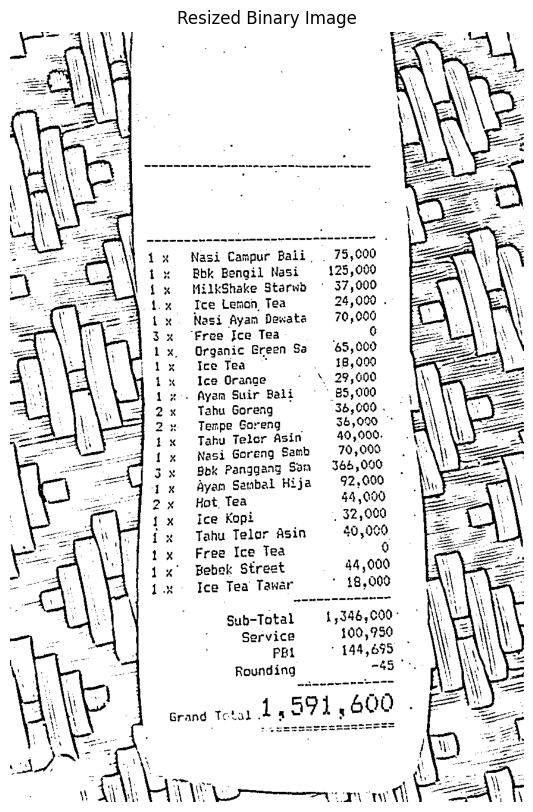

In [12]:
def resize_if_needed(image, target_width=1280):
    """Resizes image to target width ensuring high performance."""
    (h, w) = image.shape[:2]
    if w <= target_width:
        return image # No need to upscale if it's already small
    
    ratio = target_width / float(w)
    new_h = int(h * ratio)
    
    # INTER_AREA is the best for shrinking (Anti-aliasing)
    return cv2.resize(image, (target_width, new_h), interpolation=cv2.INTER_AREA)

resize_if_needed(binary_image, target_width=1280)

show_images([binary_image], ['Resized Binary Image'])

# Pipelines

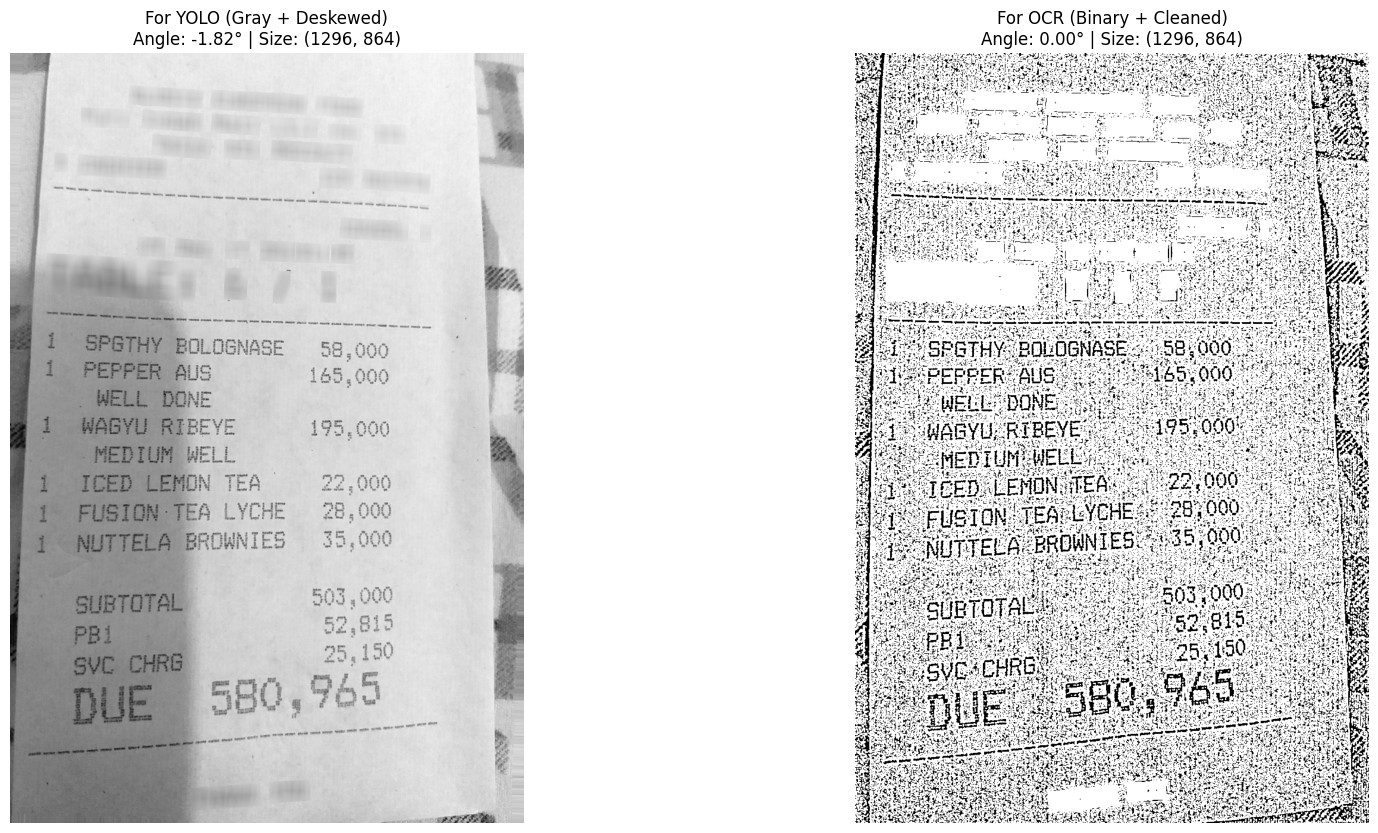

In [17]:
# --- THE TWO PIPELINES ---

def yolo_pipeline(image_path):
    """
    Goal: Clean structure, Gray, Corrected Rotation.
    Best for: Object Detection (Seeing layout, logos, tables).
    """
    # 1. Load
    if not os.path.exists(image_path): return None
    original = cv2.imread(image_path)
    
    # 2. Tool: Grayscale
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    
    # 3. Tool: Detect Skew (Need binary just for calculation)
    # Note: We use the function we defined in Cell 6 (Hough)
    # We create a temp binary just to find the angle
    temp_edges = cv2.Canny(gray, 50, 150) # Quick edge detect
    angle = get_hough_skew_angle(temp_edges) # Using Cell 6 function
    
    # 4. Tool: Rotate (Apply to Grayscale)
    deskewed_gray = rotate_image(gray, angle) # Using Cell 5/6 helper
    
    # 5. Tool: Resize
    final_output = resize_if_needed(deskewed_gray)
    
    return final_output, angle

def ocr_pipeline(image_path):
    """
    Goal: High Contrast, No Noise, Black/White.
    Best for: Text Recognition (Reading prices, names).
    """
    # 1. Load
    if not os.path.exists(image_path): return None
    original = cv2.imread(image_path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    
    # 2. Tool: Binarization (Cleaning)
    # Using our tuned Adaptive Threshold (Cell 4 logic)
    # We incorporate the "C=3 + Morph" logic here directly or call a wrapper
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
    kernel = np.ones((2, 2), np.uint8)
    clean_binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # 3. Tool: Detect Skew (From the clean binary)
    angle = get_hough_skew_angle(clean_binary)
    
    # 4. Tool: Rotate (Apply to Binary)
    deskewed_binary = rotate_image(clean_binary, angle)
    
    # 5. Tool: Resize
    final_output = resize_if_needed(deskewed_binary)
    
    return final_output, angle

# --- TEST DRIVE ---
test_path = '../data/cord/raw/train/image_1.png' # Use your difficult image

# Run YOLO Pipeline
yolo_output = yolo_pipeline(test_path)
if yolo_output is None:
    raise FileNotFoundError(f"Image not found at path: {test_path}")
yolo_result, yolo_angle = yolo_output

# Run OCR Pipeline
ocr_output = ocr_pipeline(test_path)
if ocr_output is None:
    raise FileNotFoundError(f"Image not found at path: {test_path}")
ocr_result, ocr_angle = ocr_output

# --- VISUALIZATION ---
plt.figure(figsize=(20, 10))

# 1. YOLO Result
plt.subplot(1, 2, 1)
plt.imshow(yolo_result, cmap='gray')
plt.title(f"For YOLO (Gray + Deskewed)\nAngle: {yolo_angle:.2f}° | Size: {yolo_result.shape}")
plt.axis('off')

# 2. OCR Result
plt.subplot(1, 2, 2)
plt.imshow(ocr_result, cmap='gray')
plt.title(f"For OCR (Binary + Cleaned)\nAngle: {ocr_angle:.2f}° | Size: {ocr_result.shape}")
plt.axis('off')

plt.show()